In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import requests

import io
import numpy as np
from numpy import asarray

from skimage.transform import swirl, PiecewiseAffineTransform, warp
from skimage.filters import butterworth
import pathlib
from skimage.transform import radon, rescale
from skimage.color import rgba2rgb,rgb2gray
from skimage.transform import iradon
import jupyter_capture_output


def tomo_missing_angle_clip(emoji_data,fromangle,toangle):
    total_angle = 180
    image = rgb2gray(rgba2rgb(emoji_data)) # remove alpha channel and convert to gray
    # image = rescale(image, scale=0.5, mode='reflect', channel_axis=None)
    fromangle = int(fromangle* max(image.shape)/total_angle)  # TODO radon images = max(image.shape) and angle = 180
    toangle = int(toangle* max(image.shape)/total_angle )
    theta = np.linspace(0., total_angle, max(image.shape), endpoint=False)
    sinogram = radon(image, theta=theta)

    theta = theta[fromangle:toangle]
    sinogram=sinogram[:,fromangle:toangle]

    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='shepp-logan')
    #reconstruction_fbp = np.clip((reconstruction_fbp)/0.9, 0,1)
    return reconstruction_fbp

# plt.rcParams['figure.dpi'] = 150  

import matplotlib.pyplot as plt  # NOT

%config InlineBackend.print_figure_kwargs = {'pad_inches':0} # NOT


def show(img , cmap = "gray"):
    plt.imshow(img , cmap)
    plt.axis("off")

Jupyter Capture Output v0.0.5


In [2]:
image_data = Image.open("ct_legs_scanner_309.png")
image_data = np.array(image_data.convert("RGBA")) 
image = rgb2gray(1-rgba2rgb(image_data))
image.min(),image.max()

(0.0, 1.0)

/Users/jan-hendrik/projects/ct-scanner-webapp/emoji_ct_env/lib/python3.10/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


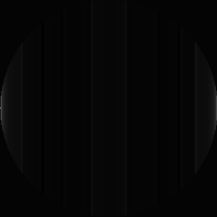

In [3]:
filtered_image1 = (tomo_missing_angle_clip(image_data, fromangle= 0,toangle = 1))
show(filtered_image1)

In [4]:
imgs = []
for i in range(0,180):
    if i%9 ==0: # take only every 9th angle
        filtered_im = tomo_missing_angle_clip(image_data, fromangle= i,toangle = i+1)
        imgs.append(filtered_im)

In [5]:
keys = []
for i in range(0,len(imgs)):
    keys.append(f"img_{i+1:0>3}")

In [6]:
import numpy as np 
import json
import base64
import zlib
import binascii
from pathlib import Path

compressed_datastack = []

for d in imgs:
    data = np.around(d, decimals=2)
    #data = zlib.compress(d)
    #data = binascii.hexlify(data)
    #data = data.decode('UTF-8')
    compressed_datastack.append(data)

json_content_compressed = dict(zip(keys, compressed_datastack))

In [7]:
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

with Path("legs_discrete.json").open("w") as jsonFile:
    json.dump(json_content_compressed, jsonFile, indent=0, sort_keys=False,cls=NumpyArrayEncoder)

(-0.5, 308.5, 308.5, -0.5)

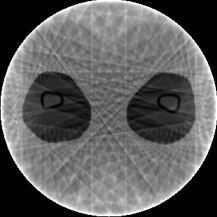

In [8]:
img_final = imgs[0]*0

for im in imgs:
    img_final += im

plt.imshow(np.clip((img_final)/40, 0,1), cmap="gray")
plt.axis("off")

# Continuous

In [9]:
imgs = []
for i in range(0,20):
    filtered_im = tomo_missing_angle_clip(image_data, fromangle= (i)*9,toangle = (i+1)*9)
    imgs.append(filtered_im)

In [10]:
compressed_datastack = []

for d in imgs:
    data = np.around(d, decimals=2)
    #data = zlib.compress(d)
    #data = binascii.hexlify(data)
    #data = data.decode('UTF-8')
    compressed_datastack.append(data)

json_content_compressed = dict(zip(keys, compressed_datastack))

In [11]:

with Path("legs_continuous.json").open("w") as jsonFile:
    json.dump(json_content_compressed, jsonFile, indent=0, sort_keys=False,cls=NumpyArrayEncoder)

(-0.5, 308.5, 308.5, -0.5)

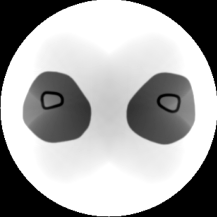

In [12]:
img_final = imgs[0]*0

for im in imgs:
    img_final += im

plt.imshow(np.clip((img_final)/20, 0,1), cmap="gray")
plt.axis("off")